In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm

import random
from math import sin, cos, sqrt, atan2, radians
from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
import time
from impacts import distance, IMPAaCS

In [2]:
# Set the size bins
max_diameter=330

diam_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 500]
diam_labs = [f'{str(i).zfill(3)}-{str(j).zfill(3)}' for i, j in zip(diam_bins[0:-1], diam_bins[1:])]
diam_range = {f'{str(i).zfill(3)}-{str(j).zfill(3)}':[i,j] for i, j in zip(diam_bins[0:-1], diam_bins[1:])}
lambda_start = {j:1+i/10 for i, j in enumerate(list(diam_range.keys()))}
lambda_end = {j:4+(np.power(i,1.2)) for i, j in enumerate(list(diam_range.keys()))}    

In [3]:
# Make dictionary with size bins and frequency
with open('sfd.csv', 'r') as f:
    freqs = pd.read_csv(f).groupby('D').sum()
los_dict = {i:0 for i in diam_labs}
his_dict = {i:0 for i in diam_labs}
for i in freqs.index.values:
    for j in range(len(diam_labs)):
        if i < diam_bins[j+1] and i > 9:
            los_dict[diam_labs[j]] += freqs.loc[i,'low']
            his_dict[diam_labs[j]] += freqs.loc[i,'high']
            break
        elif i >= diam_bins[-1]:
            los_dict[diam_labs[-1]] += freqs.loc[i,'low']
            his_dict[diam_labs[-1]] += freqs.loc[i,'high']
            break
df_freq = pd.DataFrame.from_dict({'high':his_dict, 'low':los_dict, 
                                  'lambda_start':lambda_start, 'lambda_end':lambda_end})

df_freq['frequency_factor'] = [.1+i/10 for i in range(len(diam_bins)-1)]

df_freq

,high,low,lambda_start,lambda_end,frequency_factor
010-020,120000,12000,1.0,4.000000,0.1
020-030,18000,1800,1.1,5.000000,0.2
030-040,5000,500,1.2,6.297397,0.3
040-050,3100,310,1.3,7.737193,0.4
050-060,2500,250,1.4,9.278032,0.5
060-070,2000,200,1.5,10.898648,0.6
070-080,1500,150,1.6,12.585814,0.7
080-090,1500,150,1.7,14.330412,0.8
090-100,1200,120,1.8,16.125733,0.9
100-200,2700,270,1.9,17.966610,1.0


In [4]:
# A Hack to force a lot of smaller impacters
df_freq.loc["010-020","low"] = 110000

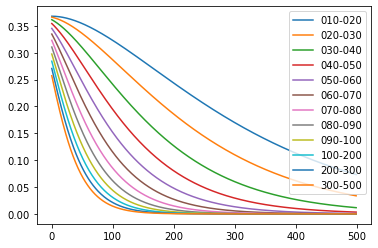

total impacts 124720.0
impacts by diameter {'010-020': 110850.0, '020-030': 7741.0, '030-040': 1873.0, '040-050': 676.0, '050-060': 578.0, '060-070': 249.0, '070-080': 188.0, '080-090': 695.0, '090-100': 826.0, '100-200': 961.0, '200-300': 58.0, '300-500': 25.0}
fraction of total {'010-020': 0.89, '020-030': 0.06, '030-040': 0.02, '040-050': 0.01, '050-060': 0.0, '060-070': 0.0, '070-080': 0.0, '080-090': 0.01, '090-100': 0.01, '100-200': 0.01, '200-300': 0.0, '300-500': 0.0}


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


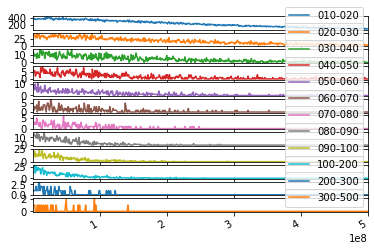

,high,low,lambda_start,lambda_end,frequency_factor,total
010-020,120000,110000,1.0,4.000000,0.000963,110850.0
020-030,18000,1800,1.1,5.000000,0.010710,7741.0
030-040,5000,500,1.2,6.297397,0.035261,1873.0
040-050,3100,310,1.3,7.737193,0.071786,676.0
050-060,2500,250,1.4,9.278032,0.059501,578.0
060-070,2000,200,1.5,10.898648,0.116374,249.0
070-080,1500,150,1.6,12.585814,0.129140,188.0
080-090,1500,150,1.7,14.330412,0.028940,695.0
090-100,1200,120,1.8,16.125733,0.019487,826.0
100-200,2700,270,1.9,17.966610,0.014400,961.0


In [5]:
t_total=500

fivehundredmillion = 500000000
freq_factor = fivehundredmillion/t_total

not_converged=True
while not_converged:

    pp = {x:np.zeros(t_total) for x in diam_labs}
    l = {x:np.linspace(y,z,t_total) for x,y,z in zip(diam_labs,df_freq['lambda_start'],df_freq['lambda_end'])}

    for D in diam_labs:
        pp[D] = l[D]*np.exp(-l[D])

    df = pd.DataFrame(data=pp)
    hits = {d:np.zeros(t_total) for d in diam_labs}

    # Main loop through time. Calculate the total number of impacts of each diameter at each time step
    for t in range(0,t_total):
        for D in diam_labs:
            hits[D][t] = np.floor(np.random.poisson(pp[D][t] / df_freq.loc[D, 'frequency_factor']))


    total_sum = np.sum([hits[d] for d in diam_labs])
    sums = {d:np.sum(hits[d]) for d in diam_labs}
    frac = {d:np.round(np.sum(hits[d])/total_sum,2) for d in diam_labs}
    
    for d in diam_labs:
        df_freq.loc[d,'total']=sums[d]
    
    good_numbers = 0
    for d in diam_labs:
        if df_freq.loc[d,'total'] < df_freq.loc[d,'low']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*random.random()
        elif df_freq.loc[d,'total'] > df_freq.loc[d,'high']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*(1+random.random())
        else:
            good_numbers+=1
    if good_numbers == df_freq.shape[0]:
        not_converged = False
    
    
    
plt.plot(df)
plt.legend(df.columns.values)
plt.show()
print('total impacts', total_sum)
print('impacts by diameter', sums)
print('fraction of total', frac)
plot_time = np.linspace(0,fivehundredmillion,t_total+1)[1:]
df = pd.DataFrame(data=hits, index=plot_time)
df.plot(subplots=True)
plt.tight_layout()
plt.show()
df_freq

In [6]:
list_impacts_export = list(range(0,500,50))
list_impacts_export.append(499)

In [7]:
impact_boundz=20
[-impact_boundz, impact_boundz]
Impc = IMPAaCS(egrid, max_depth_of_impact_melt=330, 
               lon_lims = [-impact_boundz, impact_boundz], lat_lims = [-impact_boundz, impact_boundz],
               bound_sio2=True)

In [8]:
# (grid_size [m] / 1000 [km/m])^2 [km^2] * Impc.z_discretized_km [km]
grid_area = np.power(grid_size/1000,2)
cube_volume = grid_area * Impc.z_discretized_km
print(f"cube volume {cube_volume}, in km^3")

# Get our surface are in proportion to Earth surface area
# grid area [km^2] * n_grids in row * n_grid in col
n_cubes_per_layer = Impc.n_x * Impc.n_y
sample_area = grid_area * n_cubes_per_layer
print(f"sample area {sample_area}, in km^2")
surface_area_of_earth = 507637669.626 #km^2
sample_area_ratio = sample_area / surface_area_of_earth
print(f"our sample represents {np.round(sample_area_ratio,3)} of earth's surface area")
surface_area_multiplier = 1/sample_area_ratio
print(f"we need to multiply our volume by {np.round(surface_area_multiplier,3)} to correct for sample/earth area")

cube_volume_multiplier = cube_volume * surface_area_multiplier
print(f"multiply n_cubes by {np.round(cube_volume_multiplier,1)} to get crust volume [km^3] on earth")

total_current_crust = 7.2e9 #km^3
print(f"divide by {total_current_crust} to get relative percent crust volume")

relative_percent_crust_vol_multiplier = cube_volume_multiplier / total_current_crust
print(f"the final multiplier to get relative percent volume crust is {relative_percent_crust_vol_multiplier}")

# Track the total volume of continental crust.
#volume_crust = {i:0 for i in range(10)}
n_cubes_above_60_list = []
relative_percent_crust_vol_list = []

cube volume 2592.0, in km^3
sample area 19315584.0, in km^2
our sample represents 0.038 of earth's surface area
we need to multiply our volume by 26.281 to correct for sample/earth area
multiply n_cubes by 68121.0 to get crust volume [km^3] on earth
divide by 7200000000.0 to get relative percent crust volume
the final multiplier to get relative percent volume crust is 9.461249582997854e-06


plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


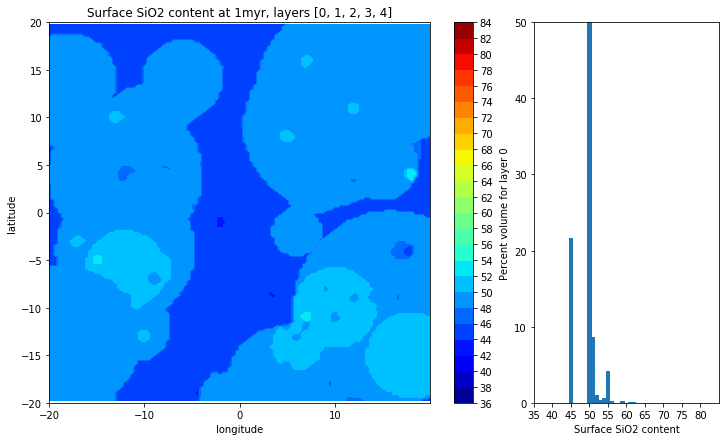

45    21.712292
47     0.026838
50    62.600644
51     8.588298
52     1.086957
53     0.402576
54     0.691090
55     4.240472
56     0.254965
59     0.254965
61     0.040258
62     0.046967
64     0.020129
67     0.033548
Name: 0, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


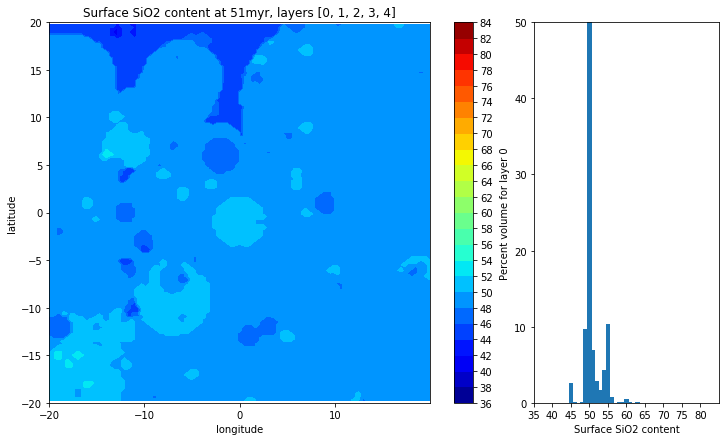

45     2.596618
47          NaN
50    59.708803
51     6.951154
52     2.865003
53     1.710950
54     4.294149
55    10.359635
56     0.744767
59     0.100644
61     0.140902
62          NaN
64          NaN
67          NaN
46     0.140902
58     0.046967
60     0.536769
48     0.040258
49     9.722222
57          NaN
63     0.040258
Name: 50, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


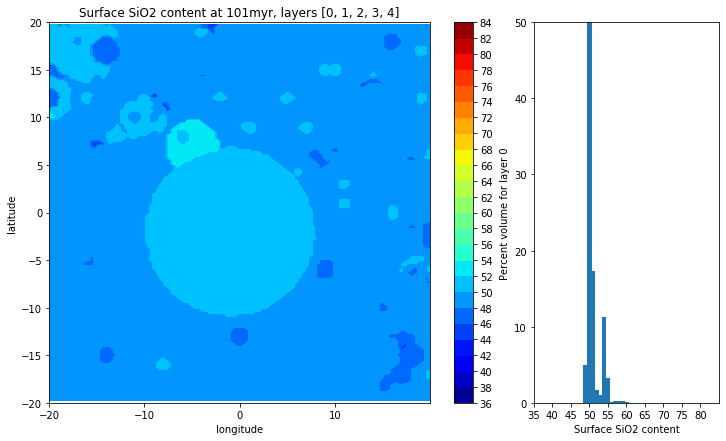

45          NaN
47          NaN
50    59.453838
51    17.377885
52     1.704240
53     1.046699
54    11.285561
55     3.301127
56     0.080515
59     0.288513
61          NaN
62          NaN
64          NaN
67          NaN
46          NaN
58     0.248256
60     0.093935
48          NaN
49     4.944981
57     0.174450
63          NaN
Name: 100, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


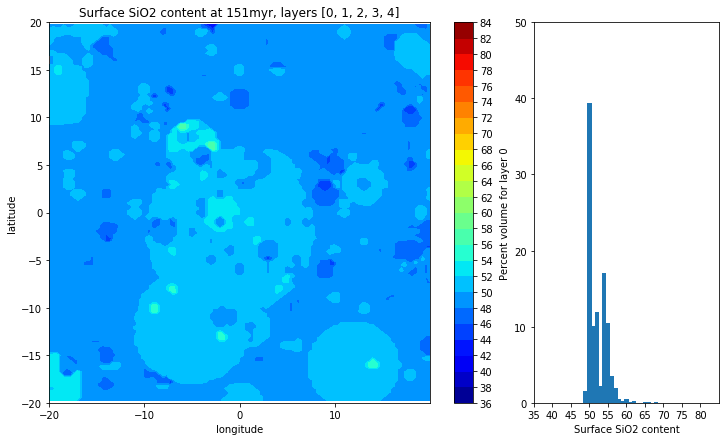

45          NaN
47          NaN
50    39.452496
51    10.084541
52    11.882716
53     2.194042
54    17.089372
55    10.540794
56     3.509125
59     0.281804
61     0.080515
62     0.228127
64          NaN
67          NaN
46          NaN
58     0.556897
60     0.456253
48          NaN
49     1.489533
57     1.925658
63          NaN
70     0.033548
65     0.107354
68     0.040258
66     0.046967
Name: 150, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


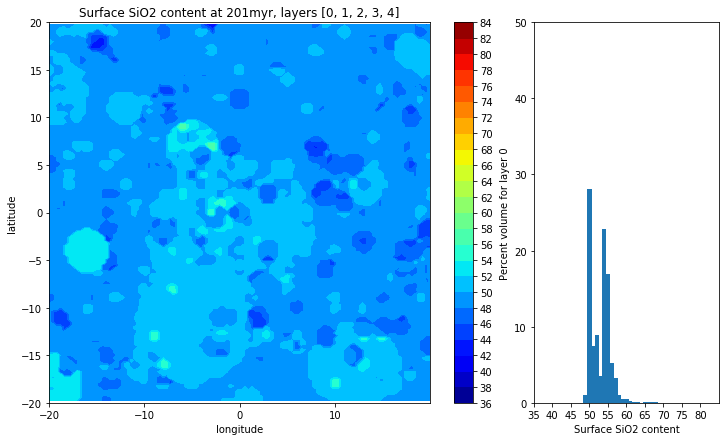

45     0.033548
47          NaN
50    28.146806
51     7.474503
52     8.863392
53     3.468867
54    22.866345
55    16.941761
56     5.186527
59     0.503221
61     0.181159
62     0.147611
64     0.013419
67     0.067096
46          NaN
58     1.033280
60     0.536769
48          NaN
49     1.006441
57     3.213902
63     0.053677
70     0.033548
65     0.120773
68     0.040258
66     0.053677
43     0.013419
Name: 200, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


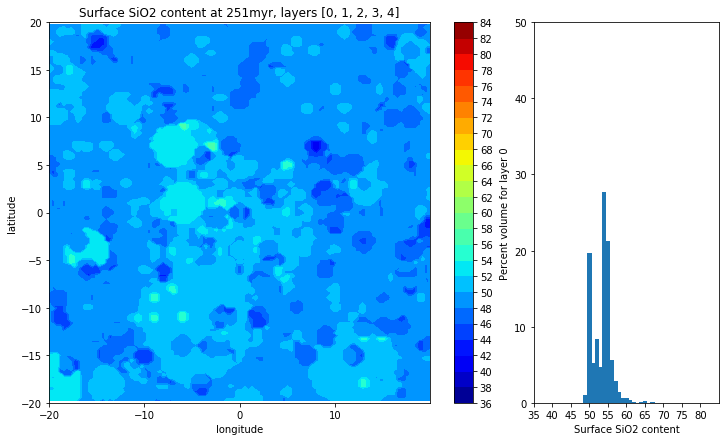

45          NaN
47          NaN
50    19.618894
51     5.220075
52     8.400429
53     4.643049
54    27.730811
55    21.323135
56     5.575684
59     0.691090
61     0.348900
62     0.161031
64     0.093935
67     0.040258
46          NaN
58     1.362050
60     0.623994
48          NaN
49     1.026570
57     2.811326
63          NaN
70     0.033548
65     0.248256
68     0.020129
66     0.013419
43     0.013419
Name: 250, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


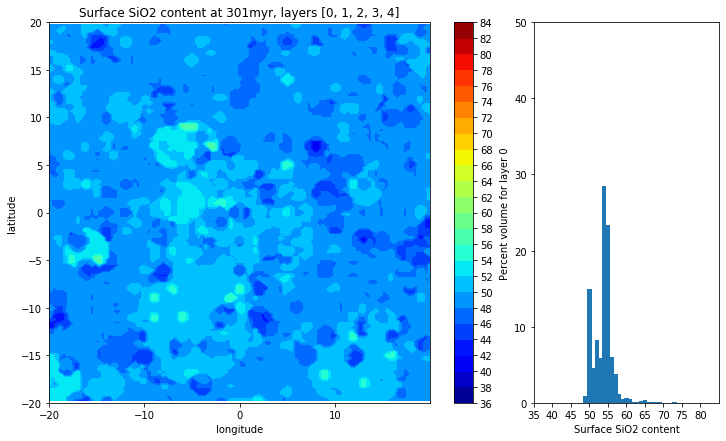

45          NaN
47          NaN
50    15.016103
51     4.515566
52     8.246108
53     5.938003
54    28.475577
55    23.349436
56     6.052067
59     0.536769
61     0.436125
62     0.134192
64     0.214707
67     0.040258
46          NaN
58     1.174181
60     0.570317
48          NaN
49     0.912507
57     3.737252
63     0.040258
70     0.033548
65     0.328771
68     0.073806
66     0.080515
43     0.013419
69     0.040258
73     0.040258
Name: 300, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


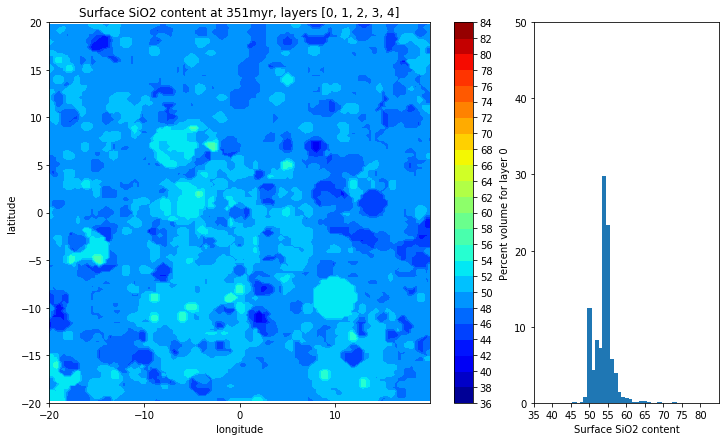

45          NaN
47          NaN
50    12.419485
51     4.287440
52     8.286366
53     7.139023
54    29.804079
55    23.349436
56     5.723296
59     0.717928
61     0.483092
62     0.147611
64     0.268384
67          NaN
46     0.046967
58     1.429147
60     0.630703
48     0.087225
49     0.697799
57     3.931830
63     0.040258
70     0.033548
65     0.248256
68     0.026838
66     0.114063
43     0.006710
69     0.040258
73     0.040258
Name: 350, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


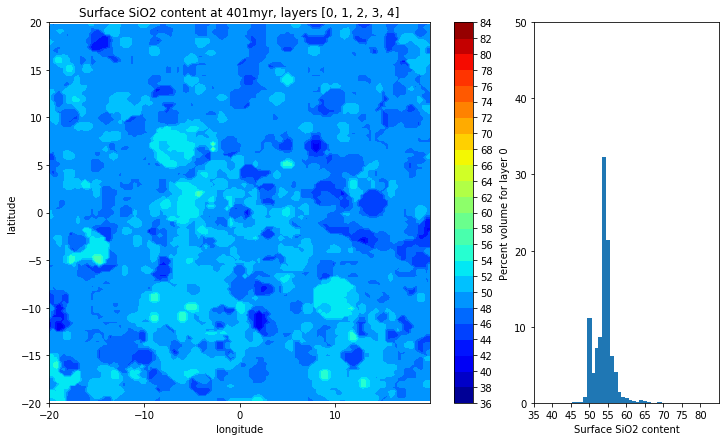

45          NaN
47     0.053677
50    11.144659
51     3.871444
52     7.253086
53     8.702362
54    32.232958
55    21.343264
56     6.192968
59     0.751476
61     0.389157
62     0.261675
64     0.308642
67          NaN
46     0.046967
58     1.355341
60     0.684380
48     0.134192
49     0.744767
57     4.106280
63     0.087225
70     0.013419
65     0.221417
68          NaN
66     0.060386
43          NaN
69     0.040258
73          NaN
Name: 400, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


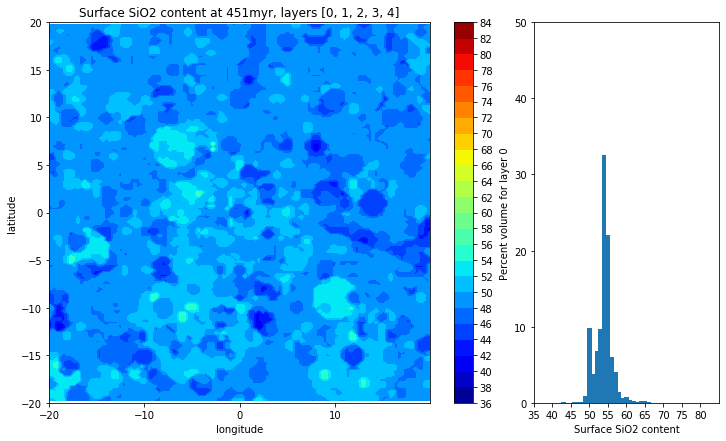

45          NaN
47     0.053677
50     9.876543
51     3.797638
52     6.843800
53     9.728932
54    32.514761
55    22.041063
56     6.058776
59     0.637413
61     0.335480
62     0.301932
64     0.254965
67          NaN
46     0.093935
58     1.388889
60     0.697799
48     0.073806
49     0.852120
57     4.079442
63     0.067096
70     0.013419
65     0.174450
68          NaN
66     0.060386
43     0.053677
69          NaN
73          NaN
Name: 450, dtype: float64
plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


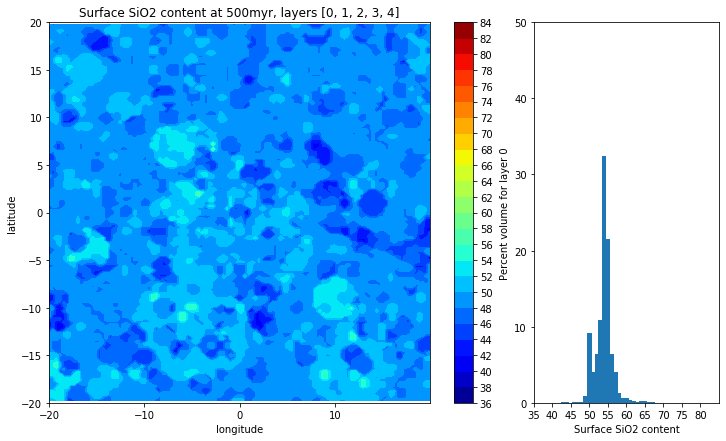

45          NaN
47     0.053677
50     9.219002
51     4.052603
52     6.427805
53    10.929952
54    32.447665
55    21.551261
56     6.447933
59     0.583736
61     0.375738
62     0.201288
64     0.234836
67     0.046967
46     0.093935
58     1.274826
60     0.650832
48     0.073806
49     0.838701
57     4.039184
63     0.067096
70     0.013419
65     0.221417
68          NaN
66     0.060386
43     0.053677
69          NaN
73          NaN
44     0.040258
Name: 499, dtype: float64


In [11]:


# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    start_time = time.time()
    for d in diam_labs:
        for i in range(int(df.loc[t,d])):
            
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
#             if impactor_diameter > 99.9:
#                 print(t, impactor_diameter)
            
            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            if np.abs(impact_lat) > impact_boundz:
                continue
            if np.abs(impact_lon) > impact_boundz:
                continue
            impact_loc = [impact_lat, impact_lon]
                
            #####      DO THE DYANMICS       #############################
            Impc.update(impact_loc, impactor_diameter, t)
            
    #layer_perc_vol = 0
    Impc.do_volume_by_layer(10) # The defauld n_layers is 1, so acting on layer 0

    count_cubes=True
    if count_cubes:
        n_cubes_above_60 = 0
        for i in range(10):
    #         print(Impc.sum_at_sio2_by_layer[i])
            for sio2_bin in list(Impc.sum_at_sio2_by_layer[i].keys()):
                if sio2_bin >= 60:
                    n_cubes_above_60 += Impc.sum_at_sio2_by_layer[i][sio2_bin]
        n_cubes_above_60_list.append(n_cubes_above_60)
        relative_percent_crust_vol_list.append(n_cubes_above_60 * relative_percent_crust_vol_multiplier)

    if it == 0:
        percent_df = pd.DataFrame(Impc.percent_volume_by_layer[0], index=[it])
    else:
        percent_df = percent_df.append(Impc.percent_volume_by_layer[0], ignore_index=True)
            
    # make a map of the results at this time
    if it in list_impacts_export:
        Impc.plot_map_and_bar(plot_figure=True, save_figure=False,
                              map_layers=[0,1,2,3,4], dist_layer=0)
        print(percent_df.iloc[-1,:])

Text(0, 0.5, 'Relative % continental crust volume')

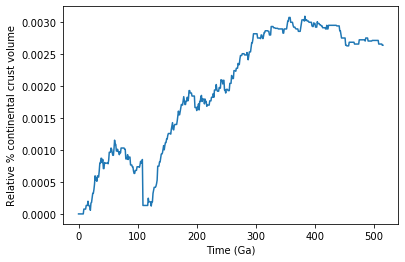

In [13]:
plt.plot(np.array(relative_percent_crust_vol_list))
plt.xlabel("Time (Ga)")
plt.ylabel("Relative % continental crust volume")

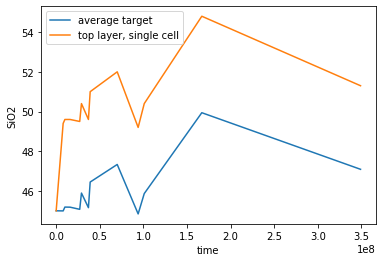

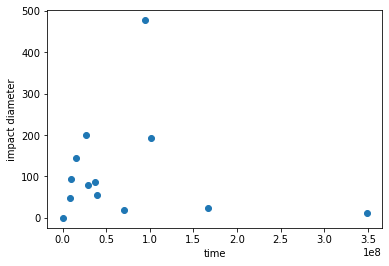

In [14]:
plt.plot(Impc.test_time, Impc.average_test_target_list)
plt.plot(Impc.test_time, Impc.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(Impc.test_time, Impc.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
I.__init__(egrid)
impact_test_diameters = [330, 73, 16, 10, 5, 2, 330, 73, 16, 10, 5, 2]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 0.18672199                             # Test scenario
                impact_lon = 0.14122179                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

# 10 X impacts teste cast

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid, bound_sio2=True)
I.__init__(egrid)
impact_test_diameters = [330, 330, 330, 330, 330, 330, 330, 330, 330, 330,
                         73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
                         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
                         10, 10,  10,  10,  10,  10,  10,  10,  10,  10, 
                         5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                         2, 2, 2, 2, 2, 2, 2, 2, 2, 2,]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 0.18672199                             # Test scenario
                impact_lon = 0.14122179                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()